## Install and import packages

In [1]:
%pip install pandas numpy sqlalchemy psycopg2 ipywidgets

  Obtaining dependency information for sqlalchemy from https://files.pythonhosted.org/packages/60/7f/ea1086136bc648cd4713a1e01869f7fc31979d67b3a8f973f5d9ab8de7e1/sqlalchemy-2.0.40-cp310-cp310-win_amd64.whl.metadata
  Obtaining dependency information for greenlet>=1 from https://files.pythonhosted.org/packages/96/28/d62835fb33fb5652f2e98d34c44ad1a0feacc8b1d3f1aecab035f51f267d/greenlet-3.1.1-cp310-cp310-win_amd64.whl.metadata
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---- ----------------------------------- 0.2/2.1 MB 7.3 MB/s eta 0:00:01
   ---------------------------------------- 2.1/2.1 MB 26.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/298.4 kB ? eta -:--:--
   ---------------------------------------- 298.4/298.4 kB ? eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import time
from ipywidgets import widgets, VBox, Label
import psycopg2
from IPython.display import display
import re
import pandas as pd
from sqlalchemy import create_engine

## Connect to DB

In [3]:
DB_NAME = "Linkedin"
DB_USER = "postgres"
DB_PASS = "Sapienza"
DB_HOST = "localhost"
DB_PORT = "5432"

def get_db_connection():
    return psycopg2.connect(
        dbname=DB_NAME, user=DB_USER, password=DB_PASS,
        host=DB_HOST, port=DB_PORT)

### Insert your personal information

In [12]:
conn = get_db_connection()
cur = conn.cursor()

cur.execute('''SELECT DISTINCT "FORMATTED_EXPERIENCE_LEVEL" FROM public."POSTING" WHERE "FORMATTED_EXPERIENCE_LEVEL" IS NOT NULL ORDER BY "FORMATTED_EXPERIENCE_LEVEL" ASC''')
experience_levels = [row[0] for row in cur.fetchall()]
cur.close()

cur = conn.cursor()
cur.execute('''SELECT DISTINCT "ID", "SKILL_NAME" FROM public."SKILL" WHERE "SKILL_NAME" IS NOT NULL ORDER BY "SKILL_NAME" ASC''')
skill_data = cur.fetchall()
skill_dict = {row[1]: row[0] for row in skill_data}
skill_names = list(skill_dict.keys())
cur.close()

name_input = widgets.Text(placeholder="Insert your name")
surname_input = widgets.Text(placeholder="Insert your surname")
email_input = widgets.Text(placeholder="Insert your email")
experience_input = widgets.Dropdown(options=experience_levels, description="Experience:")
skill_input = widgets.SelectMultiple(
    options=skill_names,
    description="Skills:",
    rows=10
)

button = widgets.Button(description="Insert Data", button_style="success")
output = widgets.Output()

def insert_data(b):
    with output:
        output.clear_output()
        name = name_input.value
        surname = surname_input.value
        email = email_input.value
        experience = experience_input.value
        selected_skills = skill_input.value
        
        try:
            cur = conn.cursor()
            query_user = '''INSERT INTO public."USERS" ("NAME", "SURNAME", "MAIL", "EXPERIENCE") 
                            VALUES (%s, %s, %s, %s) RETURNING "ID"'''
            cur.execute(query_user, (name, surname, email, experience))
            user_id = cur.fetchone()[0]
            conn.commit()
            
            if selected_skills:
                query_skill = '''INSERT INTO public."USER_SKILL" ("USER_ID", "SKILL_ID") VALUES (%s, %s)'''
                for skill_name in selected_skills:
                    skill_id = skill_dict[skill_name]
                    cur.execute(query_skill, (user_id, skill_id))
                
                conn.commit()
            
            cur.close()
            print("Data inserted successfully!")
        except Exception as e:
            print(f"Error while connecting to database: {e}")

button.on_click(insert_data)

display(widgets.VBox([
    widgets.Label("Name:"), name_input,
    widgets.Label("Surname:"), surname_input,
    widgets.Label("Email:"), email_input,
    experience_input,
    skill_input,
    button, output
]))

### Query 1

In [4]:
company_input = widgets.Text(placeholder="Insert the company name")
location_input = widgets.Text(placeholder="Insert the preferred location")
job_title_input = widgets.Text(placeholder="Insert the job title")
search_button = widgets.Button(description="Look for job posting", button_style="primary")
output = widgets.Output()

def search_jobs(b):
    with output:
        output.clear_output()
        company = company_input.value.strip() or None
        location = location_input.value.strip() or None
        job_title = job_title_input.value.strip() or None

        conn = None

        try:
            conn = get_db_connection()
            cur = conn.cursor()

            query = '''
            SELECT p."JOB_ID", c."NAME", p."LOCATION", p."TITLE" 
            FROM public."POSTING" p
            JOIN public."COMPANIES" c ON c."ID" = p."COMPANY_ID"
            WHERE (%s IS NULL OR c."NAME" ILIKE CONCAT('%%', %s, '%%'))
            AND (%s IS NULL OR p."LOCATION" ILIKE CONCAT('%%', %s, '%%')) 
            AND (%s IS NULL OR p."TITLE" ILIKE CONCAT('%%', %s, '%%'))
            ORDER BY "JOB_ID" ASC
            LIMIT 10;
            '''

            params = (
                company, company,
                location, location,
                job_title, job_title
            )

            start_time = time.time()
            cur.execute(query, params)
            rows = cur.fetchall()
            end_time = time.time()
            execution_time = end_time - start_time
            cur.close()
            conn.close()

            print(f"Query executed in {execution_time:.4f} seconds")

            if rows:
                df = pd.DataFrame(rows, columns=["JOB_ID", "COMPANY_NAME", "LOCATION", "TITLE"])
                display(df)
            else:
                print("No job postings found with the selected parameters.")

        except psycopg2.Error as e:
            if conn:
                conn.rollback()
            print(f"Database error: {e}")

        except Exception as e:
            print(f"Unexpected error: {e}")

        finally:
            if conn:
                conn.close()
                
search_button.on_click(search_jobs)

display(widgets.VBox([
    widgets.Label("Company Name:"), company_input,
    widgets.Label("Location:"), location_input,
    widgets.Label("Job Title:"), job_title_input,
    search_button, output
]))

### Query 2

In [5]:
industry_input = widgets.Text(placeholder="Insert the Industry domain")
speciality_input = widgets.Text(placeholder="Insert the company speciality")
search_button = widgets.Button(description="Look for job posting", button_style="primary")
output = widgets.Output()

def search_jobs(b):
    with output:
        output.clear_output()
        speciality = speciality_input.value.strip() or None
        industry = industry_input.value.strip() or None

        conn = None

        try:
            conn = get_db_connection()
            cur = conn.cursor()

            query = '''
            SELECT DISTINCT P."COMPANY_NAME", P."TITLE", P."VIEWS", P."APPLIES", P."EXPIRY", I."NAME", S."NAME"
            FROM public."POSTING" P 
            JOIN public."COMPANY_INDUSTRY" CI ON P."COMPANY_ID" = CI."COMPANY_ID"
            JOIN public."INDUSTRIES" I ON CI."INDUSTRY_ID" = I."ID"
            JOIN public."COMPANY_SPECIALITIES" CS ON P."COMPANY_ID" = CS."COMPANY_ID"
            JOIN public."SPECIALITIES" S ON CS."SPECIALITY_ID" = S."ID"
            JOIN public."EMPLOYEE_COUNTS" EC ON P."COMPANY_ID" = EC."COMPANY_ID" 
            WHERE EC."EMPLOYEE_COUNT" > 2000 
            AND "VIEWS" IS NOT NULL
            AND (%s IS NULL OR I."NAME" ILIKE CONCAT('%%', %s, '%%'))
            AND (%s IS NULL OR S."NAME" ILIKE CONCAT('%%', %s, '%%')) 
            ORDER BY "VIEWS" DESC
            LIMIT 10;
            '''
            
            params = (
                industry, industry if industry else None,
                speciality, speciality if speciality else None
            )

            start_time = time.time()
            cur.execute(query, params)
            rows = cur.fetchall()
            end_time = time.time()
            execution_time = end_time - start_time
            cur.close()
            conn.close()

            print(f"Query executed in {execution_time:.4f} seconds")

            if rows:
                df = pd.DataFrame(rows,
                    columns=["COMPANY_NAME", "TITLE", "VIEWS", "APPLIES", "EXPIRY", "INDUSTRY", "SPECIALITY"])
                
                df["EXPIRY"] = df["EXPIRY"].astype(float)

                df["EXPIRY"] = pd.to_datetime(df["EXPIRY"], unit="ms")
                display(df)
            else:
                print("No job postings found with the selected parameters.")

        except psycopg2.Error as e:
            if conn:
                conn.rollback()
            print(f"Database error: {e}")

        except Exception as e:
            print(f"Unexpected error: {e}")

        finally:
            if conn:
                conn.close()

search_button.on_click(search_jobs)
display(widgets.VBox([
    widgets.Label("Industry:"), industry_input,
    widgets.Label("Company Speciality:"), speciality_input,
    search_button, output
]))

### Query 3

In [6]:
def fetch_users():
    conn = get_db_connection()
    cur = conn.cursor()
    cur.execute('SELECT "ID", "NAME", "SURNAME", "MAIL" FROM public."USERS" ORDER BY "NAME";')
    users = cur.fetchall()
    cur.close()
    conn.close()
    return {f"{name} {surname} ({email})": user_id for user_id, name, surname, email in users}

user_dict = fetch_users()
user_dropdown = widgets.Dropdown(
    options=[("Select a user", None)] + list(user_dict.items()),
    description="User:",
    style={"description_width": "auto"})
currency_input = widgets.Text(placeholder="Currency (e.g., USD)", description="Currency:")
job_type_input = widgets.Text(placeholder="Job Type (e.g., Part-time)", description="Job Type:")
pay_period_input = widgets.Text(placeholder="Pay Period (e.g., Monthly)", description="Pay Period:")
industry_input = widgets.Text(placeholder="Industry (e.g., Tech)", description="Industry:")
min_salary_input = widgets.IntText(value=0, description="Min Salary:")
max_salary_input = widgets.IntText(value=100000, description="Max Salary:")
salary_slider = widgets.IntSlider(
    value=50000, min=0, max=100000, step=100, description="Quick Select:", continuous_update=True
)

def update_salary_inputs(change):
    min_salary_input.value, max_salary_input.value = salary_slider.value - 10000, salary_slider.value + 10000

salary_slider.observe(update_salary_inputs, names="value")
search_button = widgets.Button(description="Look for job postings", button_style="primary")
output = widgets.Output()

def search_jobs(b):
    with output:
        output.clear_output()
        currency = currency_input.value.strip() or None
        job_type = job_type_input.value.strip() or None
        pay_period = pay_period_input.value.strip() or None
        industry = industry_input.value.strip() or None
        min_salary = int(min_salary_input.value)
        max_salary = int(max_salary_input.value)
        selected_user = user_dropdown.value
        if not selected_user:
            print("Please select a user before searching for jobs.")
            return
        try:
            conn = get_db_connection()
            cur = conn.cursor()

            query = '''            
            SELECT p."COMPANY_NAME", p."TITLE", p."PAY_PERIOD", p."CURRENCY", p."WORK_TYPE", 
            s."MIN_SALARY", s."MAX_SALARY", i."NAME" AS industry, skill_match_count
            FROM public."POSTING" p
            JOIN public."SALARIES" s ON p."JOB_ID" = s."JOB_ID"
            JOIN public."JOB_INDUSTRIES" ji ON p."JOB_ID" = ji."JOB_ID"
            JOIN public."INDUSTRIES" i ON ji."INDUSTRY_ID" = i."ID"
            LEFT JOIN (
                SELECT js."JOB_ID", COUNT(*) AS skill_match_count
                FROM public."JOB_SKILLS" js
                JOIN public."SKILL" sk ON js."SKILL_ID" = sk."ID"
                JOIN public."USER_SKILL" us ON sk."ID" = us."SKILL_ID"
                WHERE us."USER_ID" = %s
                GROUP BY js."JOB_ID"
            ) jsm ON p."JOB_ID" = jsm."JOB_ID"
            WHERE 
                p."EXPIRY" >= (EXTRACT(EPOCH FROM NOW()) - (365 * 24 * 60 * 60)) * 1000
                AND skill_match_count IS NOT NULL
                AND (%s IS NULL OR p."CURRENCY" ILIKE CONCAT('%%', %s, '%%'))
                AND (%s IS NULL OR p."WORK_TYPE" ILIKE CONCAT('%%', %s, '%%'))
                AND (%s IS NULL OR p."PAY_PERIOD" ILIKE CONCAT('%%', %s, '%%'))
                AND (%s IS NULL OR i."NAME" ILIKE CONCAT('%%', %s, '%%'))
                AND (s."MIN_SALARY" >= %s)
                AND (s."MAX_SALARY" <= %s)
            ORDER BY skill_match_count DESC
            LIMIT 20;
            '''
            params = (
                selected_user,
                currency, currency if currency else None,
                job_type, job_type if job_type else None,
                pay_period, pay_period if pay_period else None,
                industry, industry if industry else None,
                min_salary,
                max_salary
            )

            start_time = time.time()
            cur.execute(query, params)
            rows = cur.fetchall()
            end_time = time.time()
            execution_time = end_time - start_time
            cur.close()
            conn.close()

            print(f"Query executed in {execution_time:.4f} seconds")
            
            if rows:
                df = pd.DataFrame(rows, columns=["COMPANY_NAME", "JOB_TITLE", "PAY_PERIOD", "CURRENCY", "WORK_TYPE",
                                                 "MIN_SALARY", "MAX_SALARY", "INDUSTRY", "SKILL_MATCHED"])
                display(df)
            else:
                print("No job postings found with the given filters.")

        except psycopg2.Error as e:
            if conn:
                conn.rollback()
            print(f"Database error: {e}")

        except Exception as e:
            print(f"Unexpected error: {e}")

        finally:
            if conn:
                conn.close()

search_button.on_click(search_jobs)
display(widgets.VBox([
    widgets.Label("Select User:"), user_dropdown,
    widgets.Label("Enter Job Filters:"), currency_input,
    job_type_input, pay_period_input, industry_input,
    min_salary_input, max_salary_input, salary_slider,
    search_button, output
]))

### Query 4


#### SLOW VERSION

In [16]:
def fetch_users():
    conn = get_db_connection()
    cur = conn.cursor()
    cur.execute('SELECT "ID", "NAME", "SURNAME", "MAIL", "EXPERIENCE" FROM public."USERS" ORDER BY "NAME";')
    users = cur.fetchall()
    cur.close()
    conn.close()
    return {f"{name} {surname} ({email})": (user_id) for user_id, name, surname, email, experience in users}

user_dict = fetch_users()
user_dropdown = widgets.Dropdown(
    options=[("Select a user", (None, None))] + list(user_dict.items()),
    description="User:",
    style={"description_width": "auto"}
)

search_button = widgets.Button(description="Find industries", button_style="primary")
output = widgets.Output()

def find_profitable_industries(b):
    with output:
        output.clear_output()
        selected_user_id = user_dropdown.value
        
        if not selected_user_id:
            print("Select a valid user")
            return

        conn = None
        try:
            conn = get_db_connection()
            cur = conn.cursor()

            query = """
                SELECT i."NAME" AS industry_name,
                       COUNT(p."JOB_ID") AS job_postings,
                       ROUND(AVG(COALESCE(s."MIN_SALARY", 0)), 3) AS avg_min_salary,
                       ROUND(AVG(COALESCE(s."MAX_SALARY", 0)), 3) AS avg_max_salary
                FROM public."INDUSTRIES" i
                JOIN public."JOB_INDUSTRIES" ji ON ind."ID" = ji."INDUSTRY_ID"
                JOIN public."POSTING" p ON ji."JOB_ID" = p."JOB_ID"
                LEFT JOIN public."SALARIES" s ON p."JOB_ID" = s."JOB_ID"
                WHERE p."FORMATTED_EXPERIENCE_LEVEL" = (
                    SELECT "EXPERIENCE" FROM public."USERS" WHERE "ID" = %s
                )
                AND (
                    SELECT COUNT(*) 
                    FROM public."JOB_SKILLS" js
                    WHERE js."JOB_ID" = p."JOB_ID"
                ) = (
                    SELECT COUNT(*) 
                    FROM public."JOB_SKILLS" js
                    JOIN public."USER_SKILL" us 
                        ON js."SKILL_ID" = us."SKILL_ID"
                    WHERE js."JOB_ID" = p."JOB_ID"
                      AND us."USER_ID" = %s
                )
                GROUP BY i."NAME"
                ORDER BY avg_min_salary DESC, avg_max_salary DESC
                LIMIT 10;
            """

            start_time = time.time()
            cur.execute(query, (selected_user_id, selected_user_id))
            rows = cur.fetchall()
            end_time = time.time()
            execution_time = end_time - start_time
            cur.close()
            conn.close()

            print(f"Query executed in {execution_time:.4f} seconds")

            if rows:
                df = pd.DataFrame(rows, columns=["Industry", "Job Postings", "Avg Min Salary", "Avg Max Salary"])
                display(df)
            else:
                print("No data founded for the given user")

        except psycopg2.Error as e:
            if conn:
                conn.rollback()
            print(f"Database error: {e}")

        except Exception as e:
            print(f"Unexpected error: {e}")

        finally:
            if conn:
                conn.close()

search_button.on_click(find_profitable_industries)
display(widgets.VBox([
    widgets.Label("Select a user to find more payed industries for him/her:"),
    user_dropdown,
    search_button,
    output
]))

#### FAST VERSION

In [7]:
def fetch_users():
    conn = get_db_connection()
    cur = conn.cursor()
    cur.execute('SELECT "ID", "NAME", "SURNAME", "MAIL", "EXPERIENCE" FROM public."USERS" ORDER BY "NAME";')
    users = cur.fetchall()
    cur.close()
    conn.close()
    return {f"{name} {surname} ({email})": (user_id) for user_id, name, surname, email, experience in users}

user_dict = fetch_users()
user_dropdown = widgets.Dropdown(
    options=[("Select a user", (None, None))] + list(user_dict.items()),
    description="User:",
    style={"description_width": "auto"}
)

search_button = widgets.Button(description="Find industries", button_style="primary")
output = widgets.Output()

def find_profitable_industries_optimized(b):
    with output:
        output.clear_output()
        selected_user_id = user_dropdown.value
        
        if not selected_user_id:
            print("Select a valid user")
            return

        conn = None
        try:
            conn = get_db_connection()
            cur = conn.cursor()

            query = """
SELECT industry_name,
       COUNT(job_id) AS job_postings,
       ROUND(AVG(avg_min_salary), 3) AS avg_min_salary,
       ROUND(AVG(avg_max_salary), 3) AS avg_max_salary
FROM (
    SELECT ind."NAME" AS industry_name,
           p."JOB_ID" AS job_id,
           COALESCE(s."MIN_SALARY", 0) AS avg_min_salary,
           COALESCE(s."MAX_SALARY", 0) AS avg_max_salary,
           COUNT(DISTINCT js."SKILL_ID") AS total_job_skills,
           COUNT(DISTINCT CASE WHEN us."USER_ID" = %s THEN us."SKILL_ID" END) AS matched_user_skills
    FROM public."INDUSTRIES" ind
    JOIN public."JOB_INDUSTRIES" ji ON ind."ID" = ji."INDUSTRY_ID"
    JOIN public."POSTING" p ON ji."JOB_ID" = p."JOB_ID"
    LEFT JOIN public."SALARIES" s ON p."JOB_ID" = s."JOB_ID"
    JOIN public."JOB_SKILLS" js ON p."JOB_ID" = js."JOB_ID"
    LEFT JOIN public."USER_SKILL" us ON js."SKILL_ID" = us."SKILL_ID"
    WHERE p."FORMATTED_EXPERIENCE_LEVEL" = (
        SELECT "EXPERIENCE" FROM public."USERS" WHERE "ID" = %s
    )
    GROUP BY ind."NAME", p."JOB_ID", s."MIN_SALARY", s."MAX_SALARY"
    HAVING COUNT(DISTINCT js."SKILL_ID") = 
           COUNT(DISTINCT CASE WHEN us."USER_ID" = %s THEN us."SKILL_ID" END)
) sub
GROUP BY industry_name
ORDER BY avg_min_salary DESC, avg_max_salary DESC
LIMIT 10;
            """

            start_time = time.time()
            cur.execute(query, (selected_user_id, selected_user_id, selected_user_id))
            rows = cur.fetchall()
            end_time = time.time()
            execution_time = end_time - start_time
            cur.close()
            conn.close()

            print(f"Query executed in {execution_time:.4f} seconds")

            if rows:
                df = pd.DataFrame(rows, columns=["Industry", "Job Postings", "Avg Min Salary", "Avg Max Salary"])
                display(df)
            else:
                print("No data founded for the given user")

        except psycopg2.Error as e:
            if conn:
                conn.rollback()
            print(f"Database error: {e}")

        except Exception as e:
            print(f"Unexpected error: {e}")

        finally:
            if conn:
                conn.close()

search_button.on_click(find_profitable_industries_optimized)
display(widgets.VBox([
    widgets.Label("Select a user to find more payed industries for him/her:"),
    user_dropdown,
    search_button,
    output
]))

### Query 5 

#### SLOW VERSION

In [8]:
company_name_input = widgets.Text(placeholder="Enter Company Name", description="Company:")
search_button = widgets.Button(description="Analyze Company Growth", button_style="primary")
output = widgets.Output()

def analyze_company_growth(b):
    with output:
        output.clear_output()
        company_name = company_name_input.value.strip()
        
        conn = None
        try:
            conn = get_db_connection()
            cur = conn.cursor()

            query = '''
                SELECT 
                c."NAME" AS company_name,
                jc.job_postings,
                eg.first_employee_count,                   
                eg.last_employee_count,
                eg.first_follower_count,                    
                eg.last_follower_count,
                ROUND(((eg.last_employee_count - eg.first_employee_count) * 1.0 / eg.first_employee_count), 3) * 100 AS employee_growth_ratio,
                ROUND(((eg.last_follower_count - eg.first_follower_count) * 1.0 / eg.first_follower_count), 3) * 100 AS follower_growth_ratio
                FROM public."COMPANIES" c
                JOIN (
                    SELECT 
                    "COMPANY_ID",
                    MIN("EMPLOYEE_COUNT") AS first_employee_count,
                    MAX("EMPLOYEE_COUNT") AS last_employee_count,
                    MIN("FOLLOWER_COUNT") AS first_follower_count,
                    MAX("FOLLOWER_COUNT") AS last_follower_count
                    FROM public."EMPLOYEE_COUNTS"
                    GROUP BY "COMPANY_ID"
                ) AS eg ON c."ID" = eg."COMPANY_ID"
                JOIN (
                    SELECT "COMPANY_ID", COUNT(*) AS job_postings
                    FROM public."POSTING"
                    GROUP BY "COMPANY_ID"
                ) AS jc ON c."ID" = jc."COMPANY_ID"
                WHERE (%s IS NULL OR c."NAME" ILIKE CONCAT('%%', %s, '%%'))
                ORDER BY employee_growth_ratio DESC, follower_growth_ratio DESC;
            '''
            params = (company_name, company_name if company_name else None)

            start_time = time.time()
            cur.execute(query, params)
            rows = cur.fetchall()
            end_time = time.time()
            execution_time = end_time - start_time
            cur.close()
            conn.close()

            print(f"Query executed in {execution_time:.4f} seconds")
            
            if rows:
                df = pd.DataFrame(rows, columns=["Company Name", "Job Postings", "Min Employees", 
                                                 "Max Employees", "Min Followers", "Max Followers", 
                                                 "Employee Growth Ratio", "Follower Growth Ratio"])
                display(df)
            else:
                print("No company data found.")

        except psycopg2.Error as e:
            if conn:
                conn.rollback()
            print(f"Database error: {e}")

        except Exception as e:
            print(f"Unexpected error: {e}")

        finally:
            if conn:
                conn.close()

search_button.on_click(analyze_company_growth)
display(widgets.VBox([
    widgets.Label("Enter a company name to filter results (leave blank for all):"),
    company_name_input,
    search_button,
    output
]))

#### FAST VERSION

In [10]:
def create_views():
    conn = None
    try:
        conn = get_db_connection()
        cur = conn.cursor()
        
        create_company_job_counts_view = '''
            DROP MATERIALIZED VIEW IF EXISTS company_job_counts;
            CREATE MATERIALIZED VIEW company_job_counts AS
            SELECT 
                "COMPANY_ID", 
                COUNT(*) AS job_postings
            FROM public."POSTING"
            GROUP BY "COMPANY_ID";
        '''

        create_company_growth_stats_view = '''
            DROP MATERIALIZED VIEW IF EXISTS company_growth_stats;
            CREATE MATERIALIZED VIEW company_growth_stats AS
            SELECT 
                "COMPANY_ID",
                MIN("EMPLOYEE_COUNT") AS first_employee_count,
                MAX("EMPLOYEE_COUNT") AS last_employee_count,
                MIN("FOLLOWER_COUNT") AS first_follower_count,
                MAX("FOLLOWER_COUNT") AS last_follower_count
            FROM public."EMPLOYEE_COUNTS"
            GROUP BY "COMPANY_ID";
        '''

        cur.execute(create_company_job_counts_view)
        cur.execute(create_company_growth_stats_view)
        conn.commit()
        cur.close()
        print("Views created successfully!")

    except psycopg2.Error as e:
        print(f"Error while creating views: {e}")
        if conn:
            conn.rollback()
    
    finally:
        if conn:
            conn.close()

create_views()

Views created successfully!


In [19]:
company_name_input = widgets.Text(placeholder="Enter Company Name", description="Company:")
search_button = widgets.Button(description="Analyze Company Growth", button_style="primary")
output = widgets.Output()

def analyze_company_growth_views(b):
    with output:
        output.clear_output()
        company_name = company_name_input.value.strip()
        
        conn = None
        try:
            conn = get_db_connection()
            cur = conn.cursor()

            query = '''
                SELECT 
                    c."NAME" AS company_name,
                    jc.job_postings,
                    eg.first_employee_count,                   
                    eg.last_employee_count,
                    eg.first_follower_count,                    
                    eg.last_follower_count,
                    ROUND(((eg.last_employee_count - eg.first_employee_count) * 1.0 / eg.first_employee_count), 3) * 100 AS employee_growth_ratio,
                    ROUND(((eg.last_follower_count - eg.first_follower_count) * 1.0 / eg.first_follower_count), 3) * 100 AS follower_growth_ratio
                FROM public."COMPANIES" c
                JOIN company_growth_stats eg ON c."ID" = eg."COMPANY_ID"
                JOIN company_job_counts jc ON c."ID" = jc."COMPANY_ID"
                WHERE (%s IS NULL OR c."NAME" ILIKE CONCAT('%%', %s, '%%'))
                ORDER BY employee_growth_ratio DESC, follower_growth_ratio DESC;
            '''

            params = (company_name, company_name if company_name else None)

            start_time = time.time()
            cur.execute(query, params)
            rows = cur.fetchall()
            end_time = time.time()
            execution_time = end_time - start_time
            cur.close()
            conn.close()

            print(f"Query executed in {execution_time:.4f} seconds")
            
            if rows:
                df = pd.DataFrame(rows, columns=["Company Name", "Job Postings", "Min Employees", 
                                                 "Max Employees", "Min Followers", "Max Followers", 
                                                 "Employee Growth Ratio", "Follower Growth Ratio"])
                display(df)
            else:
                print("No company data found.")

        except psycopg2.Error as e:
            if conn:
                conn.rollback()
            print(f"Database error: {e}")

        except Exception as e:
            print(f"Unexpected error: {e}")

        finally:
            if conn:
                conn.close()

search_button.on_click(analyze_company_growth_views)

display(widgets.VBox([
    widgets.Label("Enter a company name to filter results (leave blank for all):"),
    company_name_input,
    search_button,
    output
]))

### Query 6

#### SLOW VERSION

In [20]:
search_box = widgets.Text(
    description="Company:",
    placeholder="Enter company name"
)
search_button = widgets.Button(description="Analyze Jobs", button_style="primary")
output = widgets.Output()

def find_similar_companies(b):
    with output:
        output.clear_output()

        conn = None
        try:
            conn = get_db_connection()
            cur = conn.cursor()

            company_name = search_box.value

            query = """
            DROP INDEX IF EXISTS companies_name;
            DROP INDEX IF EXISTS company_industry;
            DROP INDEX IF EXISTS posting_company;
            DROP INDEX IF EXISTS employee_counts_company;
            DROP INDEX IF EXISTS salaries_job;
            DROP INDEX IF EXISTS fk_industries;
            DROP INDEX IF EXISTS fk_posting_company_id;
            DROP INDEX IF EXISTS fk_employee;
            DROP INDEX IF EXISTS fk_salaries_job_id;
                SELECT 
                c."NAME" AS company_name,
                c."STATE" AS company_state,
                s."PAY_PERIOD" AS pay_period,
                ci."INDUSTRY" AS industry,
                COUNT(p."JOB_ID") AS job_postings,
                MAX(ec."EMPLOYEE_COUNT") AS employee_count,
                MAX(ec."FOLLOWER_COUNT") AS follower_count,
                ROUND(AVG(s."MIN_SALARY"), 3) AS avg_min_salary,
                ROUND(AVG(s."MAX_SALARY"), 3) AS avg_max_salary
                FROM public."COMPANIES" c
                JOIN public."COMPANY_INDUSTRY" ci ON c."ID" = ci."COMPANY_ID"
                LEFT JOIN public."POSTING" p ON c."ID" = p."COMPANY_ID"
                LEFT JOIN public."EMPLOYEE_COUNTS" ec ON c."ID" = ec."COMPANY_ID"
                LEFT JOIN public."SALARIES" s ON p."JOB_ID" = s."JOB_ID"
                WHERE 
                    ci."INDUSTRY" = (
                        SELECT "INDUSTRY" 
                        FROM public."COMPANY_INDUSTRY" 
                        WHERE "COMPANY_ID" = (
                            SELECT "ID" FROM public."COMPANIES" WHERE "NAME" ILIKE %s
                        )
                    ) 
                    AND c."STATE" = (
                        SELECT "STATE" 
                        FROM public."COMPANIES" 
                        WHERE "NAME" ILIKE %s
                    )
                    AND c."ID" <> (
                        SELECT "ID" 
                        FROM public."COMPANIES" 
                        WHERE "NAME" ILIKE %s
                    )
                AND ec."EMPLOYEE_COUNT" IS NOT NULL
                AND ec."FOLLOWER_COUNT" IS NOT NULL
                AND s."MAX_SALARY" IS NOT NULL
                AND s."MIN_SALARY" IS NOT NULL
                GROUP BY c."NAME", c."STATE", s."PAY_PERIOD", ci."INDUSTRY"
                ORDER BY employee_count DESC, follower_count DESC
                LIMIT 10;
            """
            
            start_time = time.time()
            cur.execute(query, (company_name, company_name, company_name))
            rows = cur.fetchall()
            end_time = time.time()
            execution_time = end_time - start_time
            cur.close()
            conn.close()

            print(f"Query executed in {execution_time:.4f} seconds")

            if rows:
                df = pd.DataFrame(rows, columns=["Company Name", "State", "Pay Period", "Industry", "Job Postings", 
                                                 "Employee Count", "Follower Count", "Avg Min Salary", "Avg Max Salary"])
                display(df)
            else:
                print("No data found for the query.")

        except psycopg2.Error as e:
            if conn:
                conn.rollback()
            print(f"Database error: {e}")

        except Exception as e:
            print(f"Unexpected error: {e}")

        finally:
            if conn:
                conn.close()

search_button.on_click(find_similar_companies)
display(widgets.VBox([
    widgets.Label("Enter your company name and click below to analyze similar companies:"),
    search_box,
    search_button,
    output
]))

#### FAST VERSION

In [9]:
def create_indexes():
    conn = None
    try:
        conn = get_db_connection()
        cur = conn.cursor()

        create_indexes_sql = '''
            DROP INDEX IF EXISTS companies_name;
            DROP INDEX IF EXISTS company_industry;
            DROP INDEX IF EXISTS posting_company;
            DROP INDEX IF EXISTS employee_counts_company;
            DROP INDEX IF EXISTS salaries_job;
            DROP INDEX IF EXISTS fk_industries;
            DROP INDEX IF EXISTS fk_posting_company_id;
            DROP INDEX IF EXISTS fk_employee;
            DROP INDEX IF EXISTS fk_salaries_job_id;
            CREATE INDEX companies_name ON "COMPANIES" USING btree ("NAME");
            CREATE INDEX company_industry ON "COMPANY_INDUSTRY" USING btree ("COMPANY_ID");
            CREATE INDEX fk_industries ON public."COMPANY_INDUSTRY" USING btree ("COMPANY_ID");
            CREATE INDEX posting_company ON "POSTING" USING btree ("COMPANY_ID");
            CREATE INDEX fk_posting_company_id ON public."POSTING" USING btree ("COMPANY_ID");
            CREATE INDEX employee_counts_company ON "EMPLOYEE_COUNTS" USING btree ("COMPANY_ID");
            CREATE INDEX fk_employee ON public."EMPLOYEE_COUNTS" USING btree ("COMPANY_ID");
            CREATE INDEX salaries_job ON "SALARIES" USING btree ("JOB_ID");
            CREATE INDEX fk_salaries_job_id ON public."SALARIES" USING btree ("JOB_ID");
            '''
        cur.execute(create_indexes_sql)

        conn.commit()
        cur.close()
        print("Indexes created successfully!")

    except psycopg2.Error as e:
        print(f"Error while creating indexes: {e}")
        if conn:
            conn.rollback()

    finally:
        if conn:
            conn.close()

create_indexes()

Indexes created successfully!


In [12]:
search_box = widgets.Text(
    description="Company:",
    placeholder="Enter company name"
)
search_button = widgets.Button(description="Analyze Jobs", button_style="primary")
output = widgets.Output()

def find_similar_companies_optimized(b):
    with output:
        output.clear_output()

        conn = None
        try:
            conn = get_db_connection()
            cur = conn.cursor()

            company_name = search_box.value

            query = """
SELECT 
c."NAME" AS company_name,
c."STATE" AS company_state,
s."PAY_PERIOD" AS pay_period,
i."NAME" AS industry,
COUNT(p."JOB_ID") AS job_postings,
MAX(ec."EMPLOYEE_COUNT") AS avg_employee_count,
MAX(ec."FOLLOWER_COUNT") AS avg_follower_count,
ROUND(AVG(s."MIN_SALARY"), 3) AS avg_min_salary,
ROUND(AVG(s."MAX_SALARY"), 3) AS avg_max_salary
FROM public."COMPANIES" c
JOIN public."COMPANY_INDUSTRY" ci ON c."ID" = ci."COMPANY_ID"
JOIN public."INDUSTRIES" i on ci."INDUSTRY_ID" = i."ID"
LEFT JOIN public."POSTING" p ON c."ID" = p."COMPANY_ID"
LEFT JOIN public."EMPLOYEE_COUNTS" ec ON c."ID" = ec."COMPANY_ID"
LEFT JOIN public."SALARIES" s ON p."JOB_ID" = s."JOB_ID"
WHERE 
    i."NAME" = (
        SELECT "NAME" 
        FROM public."INDUSTRIES" i2
        JOIN public."COMPANY_INDUSTRY" ci2 on i2."ID" = ci2."INDUSTRY_ID"  
        WHERE "COMPANY_ID" = (
            SELECT "ID" FROM public."COMPANIES" WHERE "NAME" = %s
        )
    ) 
    AND c."STATE" = (
        SELECT "STATE" 
        FROM public."COMPANIES" 
        WHERE "NAME" ILIKE %s
    )
    AND c."ID" <> (
        SELECT "ID" 
        FROM public."COMPANIES" 
        WHERE "NAME" ILIKE %s
    )
AND ec."EMPLOYEE_COUNT" IS NOT NULL
AND ec."FOLLOWER_COUNT" IS NOT NULL
AND s."MAX_SALARY" IS NOT NULL
AND s."MIN_SALARY" IS NOT NULL
GROUP BY c."NAME", c."STATE", s."PAY_PERIOD", i."NAME"
ORDER BY avg_employee_count DESC, avg_follower_count DESC
LIMIT 10;
            """
            
            start_time = time.time()
            cur.execute(query, (company_name, company_name, company_name))
            rows = cur.fetchall()
            end_time = time.time()
            execution_time = end_time - start_time
            cur.close()
            conn.close()

            print(f"Query executed in {execution_time:.4f} seconds")

            if rows:
                df = pd.DataFrame(rows, columns=["Company Name", "State", "Pay Period", "Industry", "Job Postings", 
                                                 "Employee Count", "Follower Count", "Avg Min Salary", "Avg Max Salary"])
                display(df)
            else:
                print("No data found for the query.")

        except psycopg2.Error as e:
            if conn:
                conn.rollback()
            print(f"Database error: {e}")

        except Exception as e:
            print(f"Unexpected error: {e}")

        finally:
            if conn:
                conn.close()

search_button.on_click(find_similar_companies_optimized)
display(widgets.VBox([
    widgets.Label("Enter your company name and click below to analyze similar companies:"),
    search_box,
    search_button,
    output
]))

### Query 7

In [13]:
search_button = widgets.Button(description="Analyze Jobs", button_style="primary")
output = widgets.Output()

def jobs_by_country(b):
    with output:
        output.clear_output()

        conn = None
        try:
            conn = get_db_connection()
            cur = conn.cursor()

            query = """
                SELECT c."COUNTRY", COUNT(p."JOB_ID") AS total_jobs, 
                ROUND(AVG(s."MIN_SALARY"),3) AS avg_min_salary,
                ROUND(AVG(s."MED_SALARY"),3) AS avg_med_salary,
                ROUND(AVG(s."MAX_SALARY"),3) AS avg_max_salary
                FROM public."POSTING" p
                JOIN public."COMPANIES" c ON p."COMPANY_ID" = c."ID"
                LEFT JOIN public."SALARIES" s ON p."JOB_ID" = s."JOB_ID"
                GROUP BY c."COUNTRY"
                HAVING COUNT(p."JOB_ID") > 50
                ORDER BY total_jobs DESC;
            """
            
            start_time = time.time()
            cur.execute(query)
            rows = cur.fetchall()
            end_time = time.time()
            execution_time = end_time - start_time
            cur.close()
            conn.close()

            print(f"Query executed in {execution_time:.4f} seconds")

            if rows:
                df = pd.DataFrame(rows, columns=["Country", "Number of Job Offers", "Avg Min Salary", "Avg Med Salary", "Avg Max Salary"])
                display(df)
            else:
                print("No data found for the query.")

        except psycopg2.Error as e:
            if conn:
                conn.rollback()
            print(f"Database error: {e}")

        except Exception as e:
            print(f"Unexpected error: {e}")

        finally:
            if conn:
                conn.close()
search_button.on_click(jobs_by_country)

display(widgets.VBox([
    widgets.Label("Click below to analyze the job postings for each country:"),
    search_button,
    output
]))

### Query 8

In [16]:
search_button = widgets.Button(description="Analyze Remote Jobs", button_style="primary")
output = widgets.Output()

def top_5_jobs(b):
    with output:
        output.clear_output()

        conn = None
        try:
            conn = get_db_connection()
            cur = conn.cursor()

            query = """
                SELECT 
                    p."TITLE", 
                    COUNT(*) AS total_offers, 
                    SUM(CASE WHEN p."REMOTE_ALLOWED" = '1.0' THEN 1 ELSE 0 END) AS remotes_allowed, 
                    ROUND(SUM(CASE WHEN p."REMOTE_ALLOWED" = '1.0' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 3) AS percentage_remote,
                    (
                        SELECT b."TYPE"
                        FROM public."POSTING" p2
                        JOIN public."JOB_BENEFIT" jb ON p2."JOB_ID" = jb."JOB_ID"
                        JOIN public."BENEFIT" b ON jb."BENEFIT_ID" = b."ID"
                        WHERE p2."TITLE" = p."TITLE" AND jb."INFERRED" != TRUE AND b."TYPE" IS NOT NULL
                        GROUP BY b."TYPE"
                        ORDER BY COUNT(*) DESC
                        LIMIT 1
                    ) AS most_offered_benefit
                FROM public."POSTING" p
                GROUP BY p."TITLE"
                HAVING COUNT(*) > 0
                ORDER BY remotes_allowed DESC
                LIMIT 10;
            """
            start_time = time.time()
            cur.execute(query)
            rows = cur.fetchall()
            end_time = time.time()
            execution_time = end_time - start_time
            cur.close()
            conn.close()

            print(f"Query executed in {execution_time:.4f} seconds")

            if rows:
                df = pd.DataFrame(rows, columns=["Job Title", "Total Job Offers", "Remote Jobs Allowed", "Percentage Remote", "Most Offered Benefit"])
                display(df)
            else:
                print("No data found for the query.")

        except psycopg2.Error as e:
            if conn:
                conn.rollback()
            print(f"Database error: {e}")

        except Exception as e:
            print(f"Unexpected error: {e}")

        finally:
            if conn:
                conn.close()
                
search_button.on_click(top_5_jobs)
display(widgets.VBox([
    widgets.Label("Click below to analyze the remote job postings:"),
    search_button,
    output
]))

### Query 9

In [14]:
search_button = widgets.Button(description="Analyze Job Postings", button_style="primary")
output = widgets.Output()

def most_requested_jobs(b):
    with output:
        output.clear_output()

        conn = None
        try:
            conn = get_db_connection()
            cur = conn.cursor()

            query = """
            SELECT p."TITLE", 
            ROUND(AVG(p."CLOSED_TIME" - p."LISTED_TIME"),3) AS avg_closing_time,
                       SUM(CASE 
                               WHEN p."APPLIES" IS NOT NULL AND p."APPLIES" > 0 
                               THEN p."APPLIES" 
                               ELSE 0 
                           END) AS total_applies,
                       SUM(CASE 
                               WHEN p."VIEWS" IS NOT NULL AND p."VIEWS" > 0 
                               THEN p."VIEWS" 
                               ELSE 0 
                           END) AS total_views,
                       COUNT(p."TITLE") AS num_postings
                FROM public."POSTING" p
                GROUP BY p."TITLE"
                HAVING AVG(p."CLOSED_TIME" - p."LISTED_TIME") IS NOT NULL
                ORDER BY num_postings DESC
                LIMIT 10;
            """
            start_time = time.time()
            cur.execute(query)
            rows = cur.fetchall()
            end_time = time.time()
            execution_time = end_time - start_time
            cur.close()
            conn.close()

            print(f"Query executed in {execution_time:.4f} seconds")

            if rows:
                df = pd.DataFrame(rows, columns=["Job Title", "Avg Closing Time (ms)", "Total Applies", "Total Views", "Num Postings"])
                display(df)
            else:
                print("No data found for the query.")

        except psycopg2.Error as e:
            if conn:
                conn.rollback()
            print(f"Database error: {e}")

        except Exception as e:
            print(f"Unexpected error: {e}")

        finally:
            if conn:
                conn.close()

search_button.on_click(most_requested_jobs)
display(widgets.VBox([
    widgets.Label("Click below to analyze the job postings with the lowest closing time:"),
    search_button,
    output
]))

### Query 10

#### SLOW VERSION

In [15]:
search_button = widgets.Button(description="Analyze Job Skills and Industries", button_style="primary")
output = widgets.Output()

def most_payed_skills(b):
    with output:
        output.clear_output()
        conn = None
        try:
            conn = get_db_connection()
            cur = conn.cursor()
            
            query = """
            SELECT sk."SKILL_NAME", i."NAME" AS industry, 
            COUNT(js."JOB_ID") AS job_count, 
            ROUND(AVG(s."MIN_SALARY"), 2) AS avg_min_salary,
            ROUND(AVG(s."MAX_SALARY"), 2) AS avg_max_salary
            FROM public."JOB_SKILLS" js
            JOIN public."SKILL" sk ON js."SKILL_ID" = sk."ID"
            JOIN public."JOB_INDUSTRIES" ji ON js."JOB_ID" = ji."JOB_ID"
            JOIN public."INDUSTRIES" i ON ji."INDUSTRY_ID" = i."ID"
            LEFT JOIN public."SALARIES" s ON js."JOB_ID" = s."JOB_ID"
            GROUP BY sk."SKILL_NAME", i."NAME"
            ORDER BY job_count DESC, avg_max_salary DESC
            LIMIT 10;
        """
            
            start_time = time.time()
            cur.execute(query)
            rows = cur.fetchall()
            end_time = time.time()
            execution_time = end_time - start_time
            cur.close()
            conn.close()

            print(f"Query executed in {execution_time:.4f} seconds")

            if rows:
                df = pd.DataFrame(rows, columns=["Skill Name", "Industry", "Job Count", "Avg Min Salary", "Avg Max Salary"])
                display(df)
            else:
                print("No data found for the query.")

        except psycopg2.Error as e:
            if conn:
                conn.rollback()
            print(f"Database error: {e}")

        except Exception as e:
            print(f"Unexpected error: {e}")

        finally:
            if conn:
                conn.close()

search_button.on_click(most_payed_skills)
display(widgets.VBox([
    widgets.Label("Click below to analyze the job skills and industries data:"),
    search_button,
    output
]))

#### FAST VERSION

In [10]:
def create_materialized_view():
    conn = None
    try:
        conn = get_db_connection()
        cur = conn.cursor()
        
        skill_industry_summary_mv = '''
        DROP MATERIALIZED VIEW IF EXISTS skill_industry_summary; 
        CREATE MATERIALIZED VIEW skill_industry_summary AS
        SELECT 
        sk."SKILL_NAME", 
        i."NAME" AS industry, 
        COUNT(js."JOB_ID") AS job_count, 
        ROUND(AVG(s."MAX_SALARY"), 2) AS avg_max_salary
        FROM public."JOB_SKILLS" js
        JOIN public."SKILL" sk ON js."SKILL_ID" = sk."ID"
        JOIN public."JOB_INDUSTRIES" ji ON js."JOB_ID" = ji."JOB_ID"
        JOIN public."INDUSTRIES" i ON ji."INDUSTRY_ID" = i."ID"
        LEFT JOIN public."SALARIES" s ON js."JOB_ID" = s."JOB_ID"
        GROUP BY sk."SKILL_NAME", i."NAME";
        '''

        cur.execute(skill_industry_summary_mv)
        conn.commit()
        cur.close()
        print("View created successfully!")

    except psycopg2.Error as e:
        print(f"Error while creating views: {e}")
        if conn:
            conn.rollback()
    
    finally:
        if conn:
            conn.close()

create_materialized_view()

View created successfully!


In [11]:
search_button = widgets.Button(description="Analyze Job Skills and Industries", button_style="primary")
output = widgets.Output()

def most_payed_skills_optimized(b):
    with output:
        output.clear_output()
        conn = None
        try:
            conn = get_db_connection()
            cur = conn.cursor()
            
            query = """
            SELECT * FROM public.skill_industry_summary
            ORDER BY job_count DESC, avg_max_salary DESC
            LIMIT 10;
            """
            
            start_time = time.time()
            cur.execute(query)
            rows = cur.fetchall()
            end_time = time.time()
            execution_time = end_time - start_time
            cur.close()
            conn.close()

            print(f"Query executed in {execution_time:.4f} seconds")

            if rows:
                df = pd.DataFrame(rows, columns=["Skill Name", "Industry", "Job Count", "Avg Max Salary"])
                display(df)
            else:
                print("No data found for the query.")

        except psycopg2.Error as e:
            if conn:
                conn.rollback()
            print(f"Database error: {e}")

        except Exception as e:
            print(f"Unexpected error: {e}")

        finally:
            if conn:
                conn.close()

search_button.on_click(most_payed_skills_optimized)
display(widgets.VBox([
    widgets.Label("Click below to analyze the job skills and industries data:"),
    search_button,
    output
]))

# MongoDB Migration

We use an ETL (Export - Transform - Load) strategy to migrate the data previously stored into PostgreSQL into MongoDB.
Our dataset contains various information each stored into different tables, linked via foreign keys. In order to make a conscious migration that also allow to achieve efficients and optimized operations also into no relational database, is needed a structured approach. 
First of all we need to identify the entities(i.e. tables) that require more read/write operation. In our context the most important tables are: **Company**, **Posting**, **User**.
Now, instead of using conventional SQL approach, to optimize the NoSQL DB performance we store all the related entities via embeddings. JSON objects allows us to...

# ETL Migration from PostgreSQL to MongoDB

We use an **ETL (Extract - Transform - Load)** strategy to migrate data previously stored in a **PostgreSQL relational database** into **MongoDB**, a NoSQL document-oriented database.

Our dataset consists of various interrelated entities stored across multiple tables, connected via foreign keys. To ensure a **thoughtful and performance-oriented migration**, we adopted a structured approach that considers both data integrity and query optimization in the new NoSQL environment.

## Step 1: Identify High-Usage Entities

We began by identifying the entities that are most frequently accessed or modified. In our case, these are:

- **Company**
- **Posting**
- **User**

These tables form the core of our application, and optimizing their structure in MongoDB was a priority.

## Step 2: Embedding Related Data

Unlike relational databases where normalized data is spread across multiple tables, MongoDB leverages **embedded documents** to improve read performance and reduce the need for costly joins.

We took advantage of this by embedding related data directly into the main documents. For example:

- Each **Company** document includes embedded arrays of its:
  - Industries (`COMPANY_INDUSTRY`)
  - Specialities (`COMPANY_SPECIALITIES`)
  - Employee count history (`EMPLOYEE_COUNTS`)

- Each **Posting** document includes embedded:
  - Salary information (`SALARIES`)
  - Skills (`JOB_SKILLS` joined with `SKILL`)
  - Industries (`JOB_INDUSTRIES` joined with `INDUSTRIES`)
  - Benefits (`JOB_BENEFIT` joined with `BENEFIT`)

This denormalization provides a more natural data structure for MongoDB and significantly improves performance for read-heavy operations.

## Step 3: Data Transformation and Sanitization

Before loading the data into MongoDB, we performed the necessary transformations to adapt SQL data types to MongoDB-compatible formats. For example:

- **Decimal values** were converted to **floating-point numbers**, as MongoDB does not natively support the `Decimal` type.
- **Primary keys** were converted into MongoDB’s native `_id` field using `ObjectId`.
- **Foreign key references** were resolved and embedded as nested documents.

We implemented a `sanitize_for_mongo` helper function to automate this transformation and ensure compatibility.

## Step 4: Automatic Collection Creation

MongoDB collections (e.g., `companies`, `postings`) were created dynamically upon the first document insertion. There's no need to manually define schemas beforehand, thanks to MongoDB’s flexible schema design.

## Benefits of This Approach

- **Improved Read Performance:** Embedding eliminates the need for joins, enabling faster data access.
- **Document-Oriented Structure:** The embedded JSON format matches the natural data consumption patterns in many applications.
- **Scalability and Flexibility:** MongoDB allows for easy scaling and flexible schema evolution over time.


In [2]:
from decimal import Decimal
from bson import ObjectId

def sanitize_for_mongo(doc):
    def convert(value):
        if isinstance(value, Decimal):
            return float(value)
        elif isinstance(value, dict):
            return {k: convert(v) for k, v in value.items()}
        elif isinstance(value, list):
            return [convert(v) for v in value]
        else:
            return value
    return {k: convert(v) for k, v in doc.items()}


In [3]:
import psycopg2
from pymongo import MongoClient
from bson import ObjectId
#DB_NAME = "Linkedin"
#DB_USER = "postgres"
#DB_PASS = "Sapienza"
#DB_HOST = "localhost"
#DB_PORT = "5432"
# --- PostgreSQL Config ---
PG_CONFIG = {
    'dbname': 'Linkedin',
    'user': 'postgres',
    'password': 'Sapienza',
    'host': 'localhost',
    'port': 5432
}

# --- MongoDB Config ---
MONGO_URI = 'mongodb://localhost:27017/'
MONGO_DB = 'Test'

# --- Connect to PostgreSQL ---
pg_conn = psycopg2.connect(**PG_CONFIG)
pg_cur = pg_conn.cursor()

# --- Connect to MongoDB ---
mongo_client = MongoClient(MONGO_URI)
mongo_db = mongo_client[MONGO_DB]

# --- Helper to fetch data from PostgreSQL ---
def fetch_query(query, params=None):
    pg_cur.execute(query, params or ())
    cols = [desc[0] for desc in pg_cur.description]
    return [dict(zip(cols, row)) for row in pg_cur.fetchall()]

# --- Step 1: Load Companies ---
print("Migrating companies...")
companies = fetch_query("SELECT * FROM \"COMPANIES\"")

for company in companies:
    company_id = company['ID']

    # Embed industries
    industries = fetch_query("SELECT \"INDUSTRY\" FROM \"COMPANY_INDUSTRY\" WHERE \"COMPANY_ID\" = %s", (company_id,))
    company['industries'] = [ind['INDUSTRY'] for ind in industries if ind['INDUSTRY']]

    # Embed specialities
    specialities = fetch_query("SELECT \"SPECIALITY\" FROM \"COMPANY_SPECIALITIES\" WHERE \"COMPANY_ID\" = %s", (company_id,))
    company['specialities'] = [spec['SPECIALITY'] for spec in specialities if spec['SPECIALITY']]

    # Embed employee counts
    employee_counts = fetch_query("SELECT \"EMPLOYEE_COUNT\", \"FOLLOWER_COUNT\", \"TIME_RECORDED\" FROM \"EMPLOYEE_COUNTS\" WHERE \"COMPANY_ID\" = %s", (company_id,))
    company['employee_counts'] = employee_counts

    # Clean and rename keys
    company['_id'] = ObjectId()
    del company['ID']
    sanitized_company = sanitize_for_mongo(company)
    mongo_db.companies.insert_one(sanitized_company)

# --- Step 2: Load Postings ---
print("Migrating postings...")
postings = fetch_query("SELECT * FROM \"POSTING\"")

for post in postings:
    job_id = post['JOB_ID']

    # Embed salary
    salary = fetch_query("SELECT * FROM \"SALARIES\" WHERE \"JOB_ID\" = %s", (job_id,))
    post['salary'] = salary[0] if salary else {}

    # Embed skills
    skills = fetch_query("""
        SELECT s."SKILL_NAME" FROM "JOB_SKILLS" js
        JOIN "SKILL" s ON s."ID" = js."SKILL_ID"
        WHERE js."JOB_ID" = %s
    """, (job_id,))
    post['skills'] = [s['SKILL_NAME'] for s in skills if s['SKILL_NAME']]

    # Embed industries
    industries = fetch_query("""
        SELECT i."NAME" FROM "JOB_INDUSTRIES" ji
        JOIN "INDUSTRIES" i ON i."ID" = ji."INDUSTRY_ID"
        WHERE ji."JOB_ID" = %s
    """, (job_id,))
    post['industries'] = [i['NAME'] for i in industries if i['NAME']]

    # Embed benefits
    benefits = fetch_query("""
        SELECT b."TYPE" FROM "JOB_BENEFIT" jb
        JOIN "BENEFIT" b ON b."ID" = jb."BENEFIT_ID"
        WHERE jb."JOB_ID" = %s
    """, (job_id,))
    post['benefits'] = [b['TYPE'] for b in benefits if b['TYPE']]

    # Clean and rename keys
    post['_id'] = ObjectId()
    del post['JOB_ID']
    sanitized_post = sanitize_for_mongo(post)
    mongo_db.postings.insert_one(sanitized_post)

print("Migration completed.")

Migrating companies...
Migrating postings...
Migration completed.


In [4]:
import psycopg2
from pymongo import MongoClient
from bson import ObjectId
from decimal import Decimal

# --- PostgreSQL Config ---
PG_CONFIG = {
    'dbname': 'Linkedin',
    'user': 'postgres',
    'password': 'Sapienza',
    'host': 'localhost',
    'port': 5432
}

# --- MongoDB Config ---
MONGO_URI = 'mongodb://localhost:27017/'
MONGO_DB = 'Test'

# --- Connect to PostgreSQL ---
pg_conn = psycopg2.connect(**PG_CONFIG)
pg_cur = pg_conn.cursor()

# --- Connect to MongoDB ---
mongo_client = MongoClient(MONGO_URI)
mongo_db = mongo_client[MONGO_DB]

# --- Sanitize helper ---
def sanitize_for_mongo(data):
    def convert(value):
        if isinstance(value, Decimal):
            return float(value)
        if isinstance(value, memoryview):  # in case of bytea
            return value.tobytes().decode(errors='ignore')
        return value

    return {k: convert(v) for k, v in data.items() if v is not None}

# --- Helper to fetch data ---
def fetch_query(query, params=None):
    pg_cur.execute(query, params or ())
    cols = [desc[0] for desc in pg_cur.description]
    return [dict(zip(cols, row)) for row in pg_cur.fetchall()]

# --- Step: Load Users ---
print("Migrating users...")
users = fetch_query('SELECT * FROM "USERS"')

for user in users:
    user_id = user['ID']

    # Embed user skills
    skills = fetch_query("""
        SELECT s."SKILL_NAME" FROM "USER_SKILL" us
        JOIN "SKILL" s ON s."ID" = us."SKILL_ID"
        WHERE us."USER_ID" = %s
    """, (user_id,))
    user['skills'] = [s['SKILL_NAME'] for s in skills if s['SKILL_NAME']]

    # Prepare and insert into MongoDB
    user['_id'] = ObjectId()
    del user['ID']
    sanitized_user = sanitize_for_mongo(user)
    mongo_db.users.insert_one(sanitized_user)

print("User migration completed.")


Migrating users...
User migration completed.


# ETL Migration from Postgre to Neo4j

In [6]:
%pip install neo4j networkx

  Obtaining dependency information for neo4j from https://files.pythonhosted.org/packages/6a/57/94225fe5e9dabdc0ff60c88cbfcedf11277f4b34e7ab1373d3e62dbdd207/neo4j-5.28.1-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/312.3 kB ? eta -:--:--
   ---------------------------------------- 312.3/312.3 kB ? eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Query 5 Neo4j

In [12]:
from neo4j import GraphDatabase
import ipywidgets as widgets
import pandas as pd
import time

driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", "Sapienza2025!"))

company_name_input = widgets.Text(placeholder="Enter Company Name", description="Company:")
search_button = widgets.Button(description="Analyze Company Growth", button_style="primary")
output = widgets.Output()

def analyze_company_growth_neo(b):
    with output:
        output.clear_output()
        company_name = company_name_input.value.strip()

        cypher_query = """
        MATCH (c:Company)
        WHERE $company_name IS NULL OR toLower(c.name) CONTAINS toLower($company_name)
        OPTIONAL MATCH (c)<-[:BELONGS_TO_COMPANY]-(p:Posting)
        OPTIONAL MATCH (c)-[:HAS_METRICS_RECORD]->(m:MetricRecord)
        WITH c, COUNT(p) AS job_postings,
             min(m.employeeCount) AS first_employee_count,
             max(m.employeeCount) AS last_employee_count,
             min(m.followerCount) AS first_follower_count,
             max(m.followerCount) AS last_follower_count
        WHERE first_employee_count IS NOT NULL AND first_follower_count IS NOT NULL
        WITH c.name AS company_name, job_postings, 
             first_employee_count, last_employee_count,
             first_follower_count, last_follower_count,
             ROUND((toFloat(last_employee_count - first_employee_count) / first_employee_count) * 100, 3) AS employee_growth_ratio,
             ROUND((toFloat(last_follower_count - first_follower_count) / first_follower_count) * 100, 3) AS follower_growth_ratio
        RETURN company_name, job_postings, 
               first_employee_count, last_employee_count,
               first_follower_count, last_follower_count,
               employee_growth_ratio, follower_growth_ratio
        ORDER BY employee_growth_ratio DESC, follower_growth_ratio DESC
        """

        try:
            start_time = time.time()
            with driver.session() as session:
                result = session.run(cypher_query, company_name=company_name if company_name else None)
                rows = [r.data() for r in result]
            end_time = time.time()
            print(f"Query executed in {end_time - start_time:.4f} seconds")

            if rows:
                df = pd.DataFrame(rows)
                df.columns = ["Company Name", "Job Postings", "Min Employees", 
                              "Max Employees", "Min Followers", "Max Followers", 
                              "Employee Growth Ratio", "Follower Growth Ratio"]
                display(df)
            else:
                print("No company data found.")
        except Exception as e:
            print(f"Error: {e}")

# --- Collega il pulsante all'handler Neo4j ---
search_button.on_click(analyze_company_growth_neo)

# --- Visualizzazione UI ---
display(widgets.VBox([
    widgets.Label("Enter a company name to filter results (leave blank for all):"),
    company_name_input,
    search_button,
    output
]))

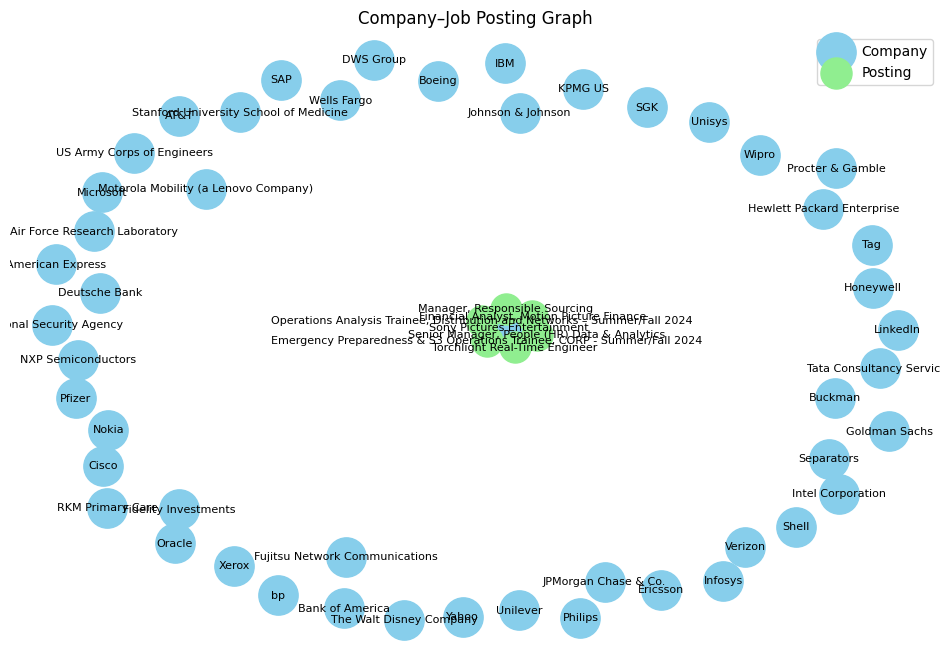

In [18]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_company_graph(company_name=None):
    query = """
    MATCH (c:Company)-[:HAS_METRICS_RECORD]->(m:MetricRecord)
    OPTIONAL MATCH (c)<-[:BELONGS_TO_COMPANY]-(p:Posting)
    WHERE $company_name IS NULL OR toLower(c.name) CONTAINS toLower($company_name)
    RETURN c.name AS company, collect(DISTINCT p.title) AS postings
    LIMIT 50
    """

    try:
        with driver.session() as session:
            result = session.run(query, company_name=company_name if company_name else None)
            records = result.data()
        
        # Crea grafo
        G = nx.Graph()
        
        for record in records:
            company = record['company']
            postings = record['postings']
            G.add_node(company, type='company')
            for posting in postings:
                if posting:
                    G.add_node(posting, type='posting')
                    G.add_edge(company, posting)

        # Disegna grafo
        pos = nx.spring_layout(G, seed=42)
        plt.figure(figsize=(12, 8))
        company_nodes = [n for n, attr in G.nodes(data=True) if attr['type'] == 'company']
        posting_nodes = [n for n, attr in G.nodes(data=True) if attr['type'] == 'posting']
        
        nx.draw_networkx_nodes(G, pos, nodelist=company_nodes, node_color='skyblue', node_size=800, label='Company')
        nx.draw_networkx_nodes(G, pos, nodelist=posting_nodes, node_color='lightgreen', node_size=500, label='Posting')
        nx.draw_networkx_labels(G, pos, font_size=8)
        nx.draw_networkx_edges(G, pos, alpha=0.5)
        
        plt.title("Company–Job Posting Graph")
        plt.axis('off')
        plt.legend()
        plt.show()

    except Exception as e:
        print(f"Error while drawing graph: {e}")

# Esempio di utilizzo
draw_company_graph(company_name_input.value.strip())
